# **Predicción de la satisfacción de niños y abuelos según la composición de su hogar y otros determinantes**
## Alejandro Betancur Quiroz 1007286609
## Julian Esteban Carvajal Ramírez 1001774262
## Wilfer Mauricio Chavarría Jaramillo 1035833003
## Alejandro Bedoya Taborda 1152226157

# Preguntas

*   Se debería dividir entre datos de entrenamiento y validación tomando como referencia las personas o tomando como referencia los hogares??? En el caso de que sea mejor con hogares, se puede usar Group Shuffle Split de sklearn
*   Verificar cuál fue el n_splits que profe dijo que era recomendable para realizar validación cruzada


# Construcción de modelos

In [ ]:
import pathlib

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import Binarizer, MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Rutas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = pathlib.Path('/content/drive/Shareddrives/Tecnicas de aprendizaje estadistico/data')
external_figures_path = pathlib.Path('/content/drive/Shareddrives/Tecnicas de aprendizaje estadistico/figuras_externas')
list(data_path.glob('*.csv'))

[PosixPath('/content/drive/Shareddrives/Tecnicas de aprendizaje estadistico/data/data_60_try.csv'),
 PosixPath('/content/drive/Shareddrives/Tecnicas de aprendizaje estadistico/data/menores.csv'),
 PosixPath('/content/drive/Shareddrives/Tecnicas de aprendizaje estadistico/data/menores_592_1_y_592_3.csv')]

## Datos

Temporalmente se carga un archivo csv que tiene datos de la tabla "Caracteristicas y composicion del hogar" la ECV de 2020. Las columnas son:


### Descripción de los datos

*   DIRECTORIO
*   P6020 - Sexo:
  *   1 Hombre
  *   2 Mujer
*   P6040 - ¿cuántos años cumplidos tiene...?
*   P6051 - ¿Cuál es el parentesco de ___ con el jefe o la jefa de este hogar?
  *   1 Jefe (a) del hogar
  *   2 Pareja, esposo (a), cónyuge, compañero(a)
  *   3 Hijo(a) hijastro(a)
  *   4 Nieto (a)
  *   5 Padre, madre, padrastro y madrastra
  *   6 Suegro o suegra
  *   7 Hermano (a), hermanastro (a)
  *   8 Yerno, nuera
  *   9 Otro pariente del jefe(a)
  *   10 Empleado(a) del servicio doméstico
  *   11 Parientes del servicio doméstico
  *   12 Trabajador
  *   13 Pensionista
  *   14 Otro pariente
*   P5502 - Actualmente…:
  *   1 No está casado(a) y vive en pareja hace menos de dos años
  *   2 No está casado(a) y vive en pareja hace dos años o más
  *   3 Está viudo(a)
  *   4 Está separado(a) o divorciado(a)
  *   5 Está soltero(a)
  *   6 Está casado(a)
*   P767 - ¿Cuántos años continuos hace que vive ___ aquí en este municipio? - Cuántos años: ______
*   P6081 - El padre de ____ ¿vive en este hogar?
  *   1 Sí
  *   2 No
  *   3 Fallecido
*   P6083 - La madre de ____ ¿vive en este hogar?
  *   1 Sí
  *   2 No
  *   3 Fallecida
*   P1895 - En general, qué tan satisfecho(a) se siente ... con su vida actualmente?
  *   10 Totalmente satisfecho(a)
  *   9
  *   ...
  *   1
  *   0 Totalmente insatisfecho(a)
*   P1896 - En general, qué tan satisfecho(a) se siente ... con su ingreso actualmente?
  *   10 Totalmente satisfecho(a)
  *   9
  *   ...
  *   1
  *   0 Totalmente insatisfecho(a)
*   P1897 - En general, qué tan satisfecho(a) se siente ... con su salud actualmente?
  *   10 Totalmente satisfecho(a)
  *   9
  *   ...
  *   1
  *   0 Totalmente insatisfecho(a)
*   P1898 - En general, qué tan satisfecho(a) se siente ... con su nivel de seguridad actualmente?
  *   10 Totalmente satisfecho(a)
  *   9
  *   ...
  *   1
  *   0 Totalmente insatisfecho(a)
*   P1899 - En general, qué tan satisfecho(a) se siente ... con su trabajo/actividad actualmente?
  *   10 Totalmente satisfecho(a)
  *   9
  *   ...
  *   1
  *   0 Totalmente insatisfecho(a)
*   P3175 - En general, ¿qué tan satisfecho/a se siente _____ con su tiempo libre?
  *   10 Totalmente satisfecho(a)
  *   9
  *   ...
  *   1
  *   0 Totalmente insatisfecho(a)
*   P1901 - ¿qué tan feliz se sintió ... el día de ayer?
  *   10 Todo el tiempo feliz
  *   9
  *   ...
  *   1
  *   0 Para nada feliz
*   P1903 - ¿qué tan preocupado(a) se sintió ... el día de ayer?
  *   10 Todo el tiempo preocupado(a)
  *   9
  *   ...
  *   1
  *   0 Para nada preocupado(a)
*   P1904 ¿qué tan triste se sintió ... el día de ayer?
  *   10 Todo el tiempo triste
  *   9
  *   ...
  *   1
  *   0 Para nada triste
*   P1905 - Qué tanto considera ... que las cosas que hace en su vida valen la pena?
  *   10 Valen totalmente la pena
  *   9
  *   ...
  *   1
  *   0 No valen la pena
*   P1927 - ¿En cuál escalón diría usted que se encuentra parado(a) en este momento?
  *   10 Mejor vida
  *   9
  *   ...
  *   1
  *   0 Peor vida

### Carga datos

In [ ]:
data = pd.read_csv(data_path.joinpath('data_60_try.csv'), index_col=0)
data = data.drop(columns=['P767', 'P6081', 'P6083'])
data = data[data['P1896'].le(10)]
data

,P6020,P6040,P6051,P5502,P1895,P1896,P1897,P1898,P1899,P3175,P1901,P1903,P1904,P1905,P1927
DIRECTORIO,,,,,,,,,,,,,,,
7247300,1,67,2,2.0,8.0,5.0,7.0,8.0,6.0,8.0,8.0,8.0,8.0,10.0,9.0
7247300,2,71,1,2.0,7.0,5.0,8.0,8.0,6.0,10.0,9.0,5.0,4.0,10.0,7.0
7247300,1,64,7,4.0,9.0,6.0,10.0,10.0,4.0,8.0,10.0,6.0,6.0,10.0,8.0
7247301,1,84,1,6.0,4.0,7.0,7.0,10.0,0.0,7.0,10.0,0.0,0.0,10.0,10.0
7247301,2,76,2,6.0,10.0,10.0,7.0,10.0,0.0,7.0,8.0,8.0,0.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7406936,1,84,1,5.0,9.0,3.0,8.0,8.0,8.0,8.0,8.0,4.0,1.0,2.0,8.0
7406979,1,67,1,2.0,6.0,6.0,6.0,7.0,5.0,5.0,7.0,2.0,2.0,6.0,5.0
7406982,2,61,1,4.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,6.0,10.0,10.0


In [ ]:
data.describe(include = 'all')

,P6020,P6040,P6051,P5502,P1895,P1896,P1897,P1898,P1899,P3175,P1901,P1903,P1904,P1905,P1927
count,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000,30914.000000
mean,1.476742,69.733228,1.855308,4.129391,7.844342,6.273565,7.126318,7.518632,6.916672,7.346671,7.507343,2.972375,2.277188,8.273242,7.433816
std,0.499467,7.893443,1.925435,1.585653,1.818477,2.538925,2.041634,1.968172,2.346324,1.930066,2.093061,2.787416,2.555322,1.744760,1.856244
min,1.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,63.000000,1.000000,3.000000,7.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.000000,0.000000,7.000000,6.000000
50%,1.000000,68.000000,1.000000,4.000000,8.000000,7.000000,7.000000,8.000000,7.000000,8.000000,8.000000,2.000000,2.000000,8.000000,8.000000
75%,2.000000,75.000000,2.000000,6.000000,9.000000,8.000000,8.000000,9.000000,8.000000,9.000000,9.000000,5.000000,4.000000,10.000000,9.000000
max,2.000000,106.000000,14.000000,6.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [ ]:
data.isnull().sum()

P6020    0
P6040    0
P6051    0
P5502    0
P1895    0
P1896    0
P1897    0
P1898    0
P1899    0
P3175    0
P1901    0
P1903    0
P1904    0
P1905    0
P1927    0
dtype: int64

## Modelos


In [ ]:
X = data.copy().drop(columns=['P1895','P6051','P5502'])
y = data.copy().filter(items=['P1895'])


In [ ]:
test_size = 0.2
random_state = 10

In [ ]:
X

,P6020,P6040,P1896,P1897,P1898,P1899,P3175,P1901,P1903,P1904,P1905,P1927
DIRECTORIO,,,,,,,,,,,,
7247300,1,67,5.0,7.0,8.0,6.0,8.0,8.0,8.0,8.0,10.0,9.0
7247300,2,71,5.0,8.0,8.0,6.0,10.0,9.0,5.0,4.0,10.0,7.0
7247300,1,64,6.0,10.0,10.0,4.0,8.0,10.0,6.0,6.0,10.0,8.0
7247301,1,84,7.0,7.0,10.0,0.0,7.0,10.0,0.0,0.0,10.0,10.0
7247301,2,76,10.0,7.0,10.0,0.0,7.0,8.0,8.0,0.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7406936,1,84,3.0,8.0,8.0,8.0,8.0,8.0,4.0,1.0,2.0,8.0
7406979,1,67,6.0,6.0,7.0,5.0,5.0,7.0,2.0,2.0,6.0,5.0
7406982,2,61,10.0,10.0,10.0,10.0,10.0,10.0,5.0,6.0,10.0,10.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

### Referencias

Referencia de *scikit-learn:* https://scikit-learn.org/stable/modules/cross_validation.html

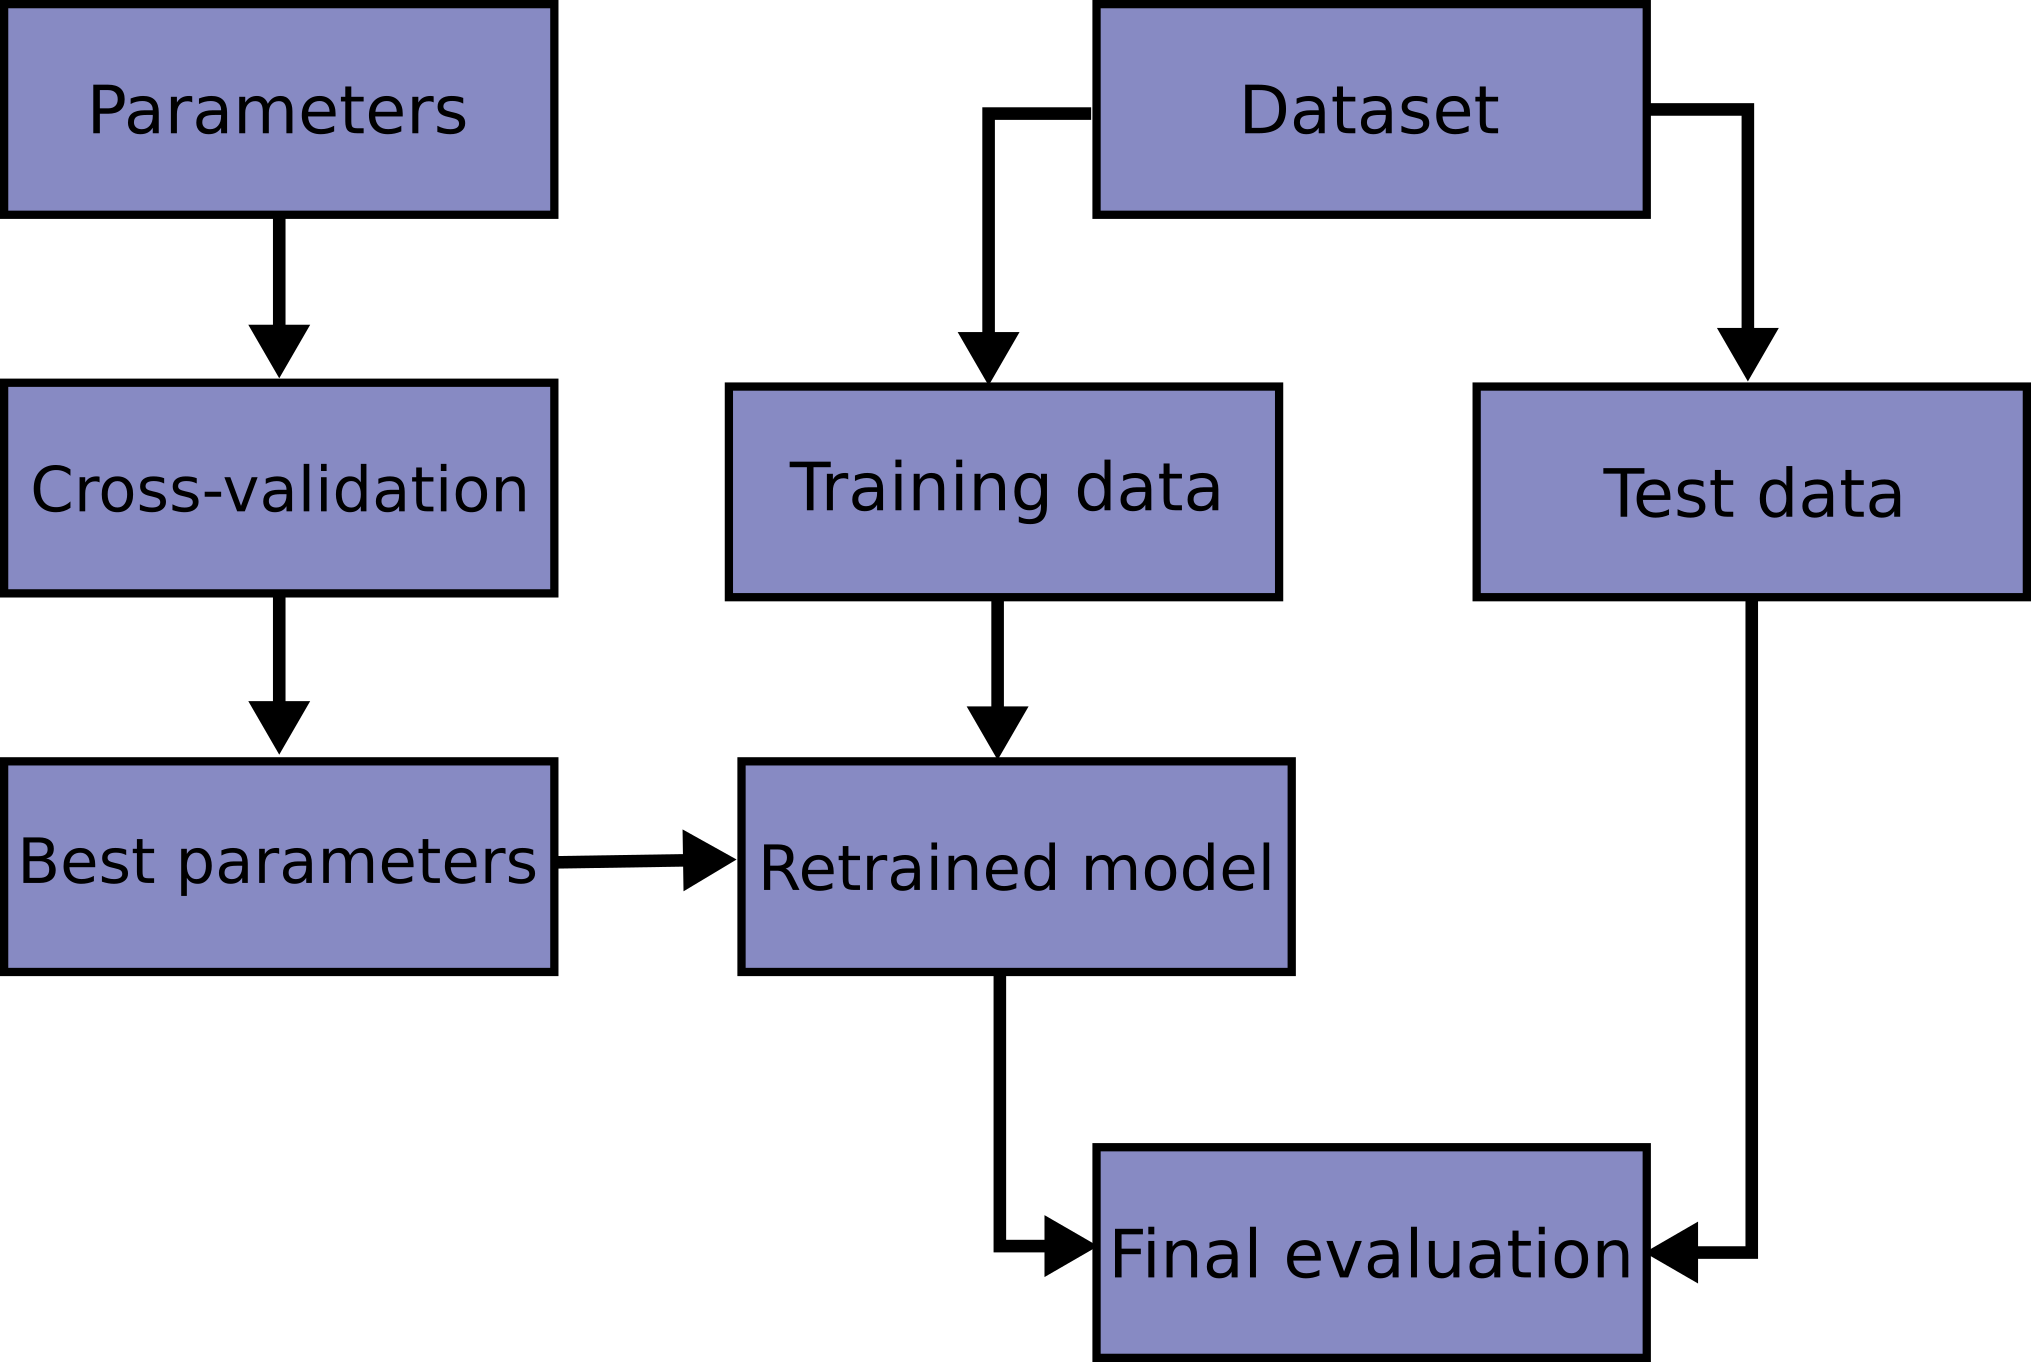

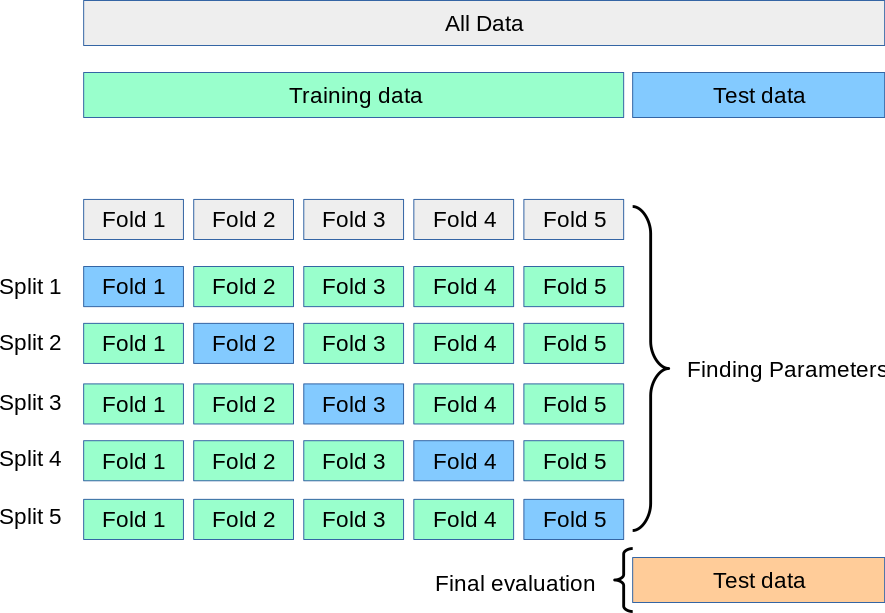

### Preprocesamiento de los datos

#### P6020 - Sexo

Esta varaible originalmente está como 1 para hombres y 2 para mujeres. Con Binarizer se lleva a hombres 0 y mujeres 1

In [ ]:
data[['P6020']].values

array([[1],
       [2],
       [1],
       ...,
       [2],
       [2],
       [1]])

In [ ]:
binarizer = Binarizer(threshold=1).fit(data[['P6020']].values)  # fit does nothing
binarizer.transform(data[['P6020']].values)

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

#### P6040 - ¿cuántos años cumplidos tiene...?

Se usa MaxAbsScaler cuyo principio es

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

where min, max = feature_range.

In [ ]:
transformer = MinMaxScaler().fit(data[['P6040']])
transformer.transform(data[['P6040']])

array([[0.15217391],
       [0.23913043],
       [0.08695652],
       ...,
       [0.02173913],
       [0.13043478],
       [0.06521739]])

#### Variables categoricas (P6051, P5502)
Usando OneHotEncoder para no darle más peso a unas categorias sobre las otras

In [ ]:
enc = OneHotEncoder()
enc.fit(data[['P6051']])
print(enc.categories_)
print(enc.transform(data[['P6051']]).toarray().shape)
print(enc.transform(data[['P6051']]).toarray())

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])]
(30914, 14)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
enc = OneHotEncoder()
enc.fit(data[['P5502']])
print(enc.categories_)
print(enc.transform(data[['P5502']]).toarray().shape)
print(enc.transform(data[['P5502']]).toarray())

[array([1., 2., 3., 4., 5., 6.])]
(30914, 6)
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


#### Variables de satisfacción y felicidad (P1895, P1896, P1897, P1898, P1899, P3175, P1901, P1903, P1904, P1905, P1927)

En todas estas variables se da una respues del tipo:
*   10 Todo el tiempo triste
*   9
*   ...
*   1
*   0 Para nada triste

Se usa 

habrían 2 opciones.

La primera opción es usando StandardScaler y escala los datos entre -1 y 1, pero forzando a que use una media $\mu=5$ y una desviación estándar $\sigma=5$. Esto para centrar los valores entre -1 y 1 pero asegurandose de que todos los 10 tenga un valor de 1, todos los 5 un valor de 0 y todos los 0 un valor de -1. Cosa que no pasaría se se usaran las medidas de centro y escala propias de los datos. 

Esta buscaría que valores distinguir entre valor de satisfacción alta y baja, con correspondecia numérica y de signos

In [ ]:
transformer = StandardScaler().fit(np.array([10, 0, 10, 0]).reshape(-1, 1))
print(transformer.mean_, transformer.scale_)
transformer.transform(data[['P1895']])

[5.] [5.]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[0.6],
       [0.4],
       [0.8],
       ...,
       [1. ],
       [1. ],
       [1. ]])

La segunda opción, es usar MinMaxScaler para llevar los datos a valores entre 0 y 1

In [ ]:
transformer = MinMaxScaler().fit(data[['P1896']])
transformer.transform(data[['P1896']])

array([[0.5],
       [0.5],
       [0.6],
       ...,
       [1. ],
       [1. ],
       [1. ]])

###  Tuning the hyper-parameters

In [ ]:
base_estimator = KNeighborsClassifier()

In [ ]:
param_grid = {
    'n_neighbors':np.arange(1, 30, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    }

In [ ]:
sh = HalvingGridSearchCV(estimator=base_estimator, param_grid=param_grid, cv=5, factor=3, verbose=1)
sh_fit = sh.fit(X_train.values, y_train.values.ravel())
print(sh_fit.best_params_)
print(sh_fit.best_score_)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 110
max_resources_: 24731
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 480
n_resources: 110
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
----------
iter: 1
n_candidates: 160
n_resources: 330
Fitting 5 folds for each of 160 candidates, totalling 800 fits
----------
iter: 2
n_candidates: 54
n_resources: 990
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 3
n_candidates: 18
n_resources: 2970
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 4
n_candidates: 6
n_resources: 8910
Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
0.46934804404390784


### Pipeline sin Tuning hyper-parameters

In [ ]:
data.columns

Index(['P6020', 'P6040', 'P6051', 'P5502', 'P1895', 'P1896', 'P1897', 'P1898',
       'P1899', 'P3175', 'P1901', 'P1903', 'P1904', 'P1905', 'P1927'],
      dtype='object')

In [ ]:
preprocessor = ColumnTransformer(
    [('age_', MinMaxScaler(),  ['P6040']),
     ('satisfaction_', MinMaxScaler(),  ['P1896', 'P1897', 'P1898', 'P1899', 'P3175', 'P1901', 'P1903', 'P1904', 'P1905', 'P1927'])
     ])
preprocessor.fit(data)

ColumnTransformer(transformers=[('age_', MinMaxScaler(), ['P6040']),
                                ('satisfaction_', MinMaxScaler(),
                                 ['P1896', 'P1897', 'P1898', 'P1899', 'P3175',
                                  'P1901', 'P1903', 'P1904', 'P1905',
                                  'P1927'])])

In [ ]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(
        n_neighbors=25,
        algorithm='auto',
        metric='manhattan',
        weights='distance'))
    ])


In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('age_', MinMaxScaler(),
                                                  ['P6040']),
                                                 ('satisfaction_',
                                                  MinMaxScaler(),
                                                  ['P1896', 'P1897', 'P1898',
                                                   'P1899', 'P3175', 'P1901',
                                                   'P1903', 'P1904', 'P1905',
                                                   'P1927'])])),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=25,
                                      weights='distance'))])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
X_test

,P6020,P6040,P1896,P1897,P1898,P1899,P3175,P1901,P1903,P1904,P1905,P1927
DIRECTORIO,,,,,,,,,,,,
7259678,1,70,7.0,9.0,8.0,8.0,8.0,8.0,2.0,0.0,10.0,9.0
7282374,1,85,3.0,10.0,9.0,9.0,8.0,8.0,0.0,0.0,10.0,7.0
7281709,2,62,10.0,10.0,5.0,8.0,10.0,10.0,0.0,0.0,9.0,10.0
7253977,2,65,10.0,10.0,10.0,10.0,10.0,10.0,2.0,1.0,10.0,10.0
7365732,2,60,6.0,8.0,5.0,7.0,6.0,7.0,6.0,3.0,10.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7400054,2,62,6.0,8.0,7.0,7.0,7.0,10.0,0.0,0.0,8.0,8.0
7364768,2,81,10.0,10.0,10.0,7.0,10.0,0.0,10.0,0.0,10.0,6.0
7256347,2,60,7.0,10.0,10.0,10.0,8.0,9.0,0.0,0.0,9.0,9.0


In [ ]:
y_pred[0]

8.0

In [ ]:
y_test

,P1895
DIRECTORIO,
7259678,9.0
7282374,9.0
7281709,10.0
7253977,10.0
7365732,10.0
...,...
7400054,9.0
7364768,8.0
7256347,10.0


In [ ]:
accuracy_score(y_test.values, y_pred)

0.4889212356461265

In [ ]:
f1_score(y_test.values, y_pred, average='weighted')

0.4823094448930402

In [ ]:
confusion_matrix(y_test, y_pred,  labels=None, sample_weight=None, normalize=None)

array([[   5,    0,    0,    1,    0,    0,    2,    1,    1,    0,    3],
       [   0,    2,    2,    4,    1,    4,    0,    1,    1,    1,    1],
       [   1,    0,    6,    6,    4,    7,    4,    7,    4,    0,    3],
       [   1,    0,    2,   13,   13,   14,    2,    9,    5,    0,    2],
       [   0,    0,    2,    7,   15,   40,   18,   18,   15,    0,    1],
       [   1,    0,    2,    6,    6,  151,   85,   55,   60,    4,   29],
       [   0,    0,    0,    4,   11,   92,  146,  160,   91,    6,   21],
       [   0,    0,    0,    2,    3,   41,  106,  372,  400,   25,   46],
       [   0,    0,    0,    2,    2,   29,   64,  296, 1041,  141,  115],
       [   0,    0,    1,    0,    0,   10,   10,   65,  464,  363,  120],
       [   0,    0,    2,    2,    1,    8,   13,   36,  196,  119,  909]])

# Menores de edad

Valor se refiere al valor de la satisfacción con la vida que tiene el infante.

En cuidador se tiene las siguientes categorías:
* 1 Asiste a un hogar comunitario, jardín, centro de desarrollo infantil o colegio
* 2 Con su padre o madre en la casa
* 3 Con su padre o madre en el trabajo
* 4 Con empleado/a o niñero/a en la casa
* 5 Al cuidado de un/a pariente de 18 años o más
* 6 Al cuidado de un/a pariente menor de 18 años
* 7 En casa solo
* 8 Otro

Cada actividad se refiere a cuántas veces realiza la actividad correspondiente, estas actividades tienen peso e influyen en la satisfacción con la vida que tiene el infante.

La frecuencia tiene las siguientes categorías:

* 1 Todos los días
* 2 Al menos una vez a la semana pero no cada día
* 3 Al menos una vez al mes, pero no cada semana
* 4 Al menos una vez al mes, pero no todos los meses

Los pesos de las actividades son las siguientes:
* **Leer:** se refiere a la actividad de que el infante lea libros de cuentos, historias o bien sea de dibujos, esta variable tiene un peso de 0.6, es importante que el infante lea, estimule su imaginación y adquiera concentración.

* **Jugar:** se refiere a la actividad de jugar juegos de rondas infantiles, tiene un peso de 0.7 porque el infante estimula su imaginacion, adquiere habilidades psicomotrices y expresar sus emociones.

* **Salir:** se refiere a la actividad de salir al parque por lo que el niño adquiere habilidades psicomotrices, sociales además de sentir libertad por lo que esta tiene un peso de 0.85.

* **VerTV:** se refiere a la actividad de mirar televisión, ayuda en menor medida a socializar, pero primordialmente es para distracción y reducción de tensiones, por lo que tiene un valor de 0.35

* **Deporte:** se refiere a la actividad de realizar algún deporte, mantiene al infante sano, aumenta sus capacidades físicas, mentales y sociales, además de estimular el crecimiento óseo y muscular, tiene un peso de 1.

* **DispositivosElectronicos:** se refiere a la actividad de jugar o usar dispositivos electronicos, ya sean smartphones, consolas, tablets, etc. si bien desarrolla su capacidad cerebral y destreza con los dispositivos electronicos, traen consecuencias negativas como obesidad y déficit de atención por lo que tiene un peso de 0.2.


## Carga de datos

AttributeError: ignored

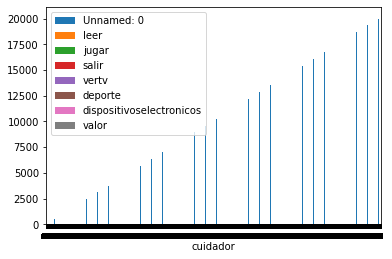

In [ ]:
menores = pd.read_csv(data_path.joinpath('menores.csv'), index_col="cuidador")
otro=pd.read_csv(data_path.joinpath('menores_592_1_y_592_3.csv'), index_col=0)
menores
menores.plot(kind = 'bar').notnull()

In [ ]:
otro

### Adecuación de datos

In [ ]:
valores = menores.drop(columns=['cuidador', 'valor'])
valores

In [ ]:
pesos = [0.6,0.7,0.85,0.35,1,0.2]
for i in range(20119):
  suma=0
  for x in range(6):
    if valores.iloc[i][x] != 0:
      valor=(valores.iloc[i][x]/valores.iloc[i][x])*(1/valores.iloc[i][x])*pesos[x]
    else:
      valor=0
    suma=suma+valor
  menores['valor'].iloc[i]=suma

In [ ]:
for i in range(20119):
  suma=0
  if menores['cuidador'].iloc[i] == 1:
    suma=3
  elif menores['cuidador'].iloc[i] == 2:
    suma=8
  elif menores['cuidador'].iloc[i] == 3:
    suma=7
  elif menores['cuidador'].iloc[i] == 4:
    suma=6
  elif menores['cuidador'].iloc[i] == 5:
    suma=4
  elif menores['cuidador'].iloc[i] == 6:
    suma=5
  elif menores['cuidador'].iloc[i] == 7:
    suma=1
  elif menores['cuidador'].iloc[i] == 8:
    suma=2    
  menores['valor'].iloc[i]=math.floor(menores['valor'].iloc[i]+suma-1)

## Modelo

In [ ]:
X = menores.copy().drop(columns=['valor'])
y = menores.copy().filter(items=['valor'])

In [ ]:
test_size = 0.3
random_state = 8

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

###  Tuning the hyper-parameters

In [ ]:
base_estimator = KNeighborsClassifier()

In [ ]:
param_grid = {
    'n_neighbors':np.arange(1, 30, 2),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    }

In [ ]:
sh = HalvingGridSearchCV(estimator=base_estimator, param_grid=param_grid, cv=5, factor=3, verbose=1)
sh_fit = sh.fit(X_train, y_train)
print(sh_fit.best_params_)
print(sh_fit.best_score_)

### Pipeline

In [ ]:
pipe = Pipeline([
    ('model', KNeighborsClassifier(
        n_neighbors=11,
        algorithm='auto',
        metric='manhattan',
        weights='distance'))
    ])


In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
accuracy_score(y_test.values, y_pred)

In [ ]:
f1_score(y_test.values, y_pred, average='weighted')

In [ ]:
confusion_matrix(y_test, y_pred,  labels=None, sample_weight=None, normalize=None)

El modelo es válido porque el score es 97% ~ 98%

# Reporte técnico

# Introducción
El presente trabajo va referido al análisis de datos suministrados por el Departamento Administrativo Nacional de Estadística (DANE) específicamente tomando los datos de la **[Encuesta de Calidad de Vida 2020](https://www.dane.gov.co/index.php/estadisticas-por-tema/pobreza-y-condiciones-de-vida/calidad-de-vida-ecv)** el cual es un instrumento diseñado para realizar el seguimiento y la medición de las condiciones socioeconómicas de los habitantes de una región. Esta investigación cuantifica y caracteriza las condiciones de vida de los colombianos incluyendo variables relacionadas con la vivienda, las personas para los que se incluyen variables de: educación, salud, cuidado de los niños, fuerza de trabajo, gastos e ingresos, etc., y los hogares que involucra variables como: tenencia de bienes y percepción del jefe o del cónyuge sobre las condiciones de vida en el hogar.

# Objetivo
- Realizar un análisis descriptivo de los datos suministrados por el DANE.
- Desarrollar modelo predictivo para predecir el nivel de satisfacción de niños y abuelos de acuerdo con la composición del hogar y actividades realizadas diariamente.
- Entender como un abuelo y un niño o niña pueden estar satisfechos con su vida, a través de la construcción de variables predictivas.
- Crear aplicación web para la exploración de resultados.
- Crear un video para promocionar el estudio realizado y dar a conocer los resultados y conclusiones.

# Encuesta de Calidad de Vida 2020

La base de datos empleada corresponde a la **[Encuesta de Calidad de Vida 2020](https://www.dane.gov.co/index.php/estadisticas-por-tema/pobreza-y-condiciones-de-vida/calidad-de-vida-ecv)** (ECV-2020), realizada por el Departamento Administrativo Nacional de Estadísticas (DANE). La cual se ha realizado periódicamente desde aproximadamente 20 años y de forma anual desde el año 2010.  Así mismo, la aplicación de esta encuesta se ha realizado desde sus inicios en las principales regiones del país, sin embargo, desde el año 2017 se extendió su aplicación a todas las regiones del país.

La ECV es una operación estadística que tiene como objetivo caracterizar aspectos relacionados con el bienestar de los hogares de todo Colombia, tanto en área urbanas, cabeceras municipales y áreas rurales alejadas. El análisis posterior de esta encuesta ha permitido determinar y explicar los diferentes niveles de vida existentes en la sociedad colombiana. Además, es la fuente de información principal del cálculo del Índice de Pobreza Multidimensional (IPM).

La encuesta de 2020 incluye una lista de capítulos base que se ha venido manteniendo desde 2010, estos se describen brevemente a continuación:

1. [Datos de la vivienda](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F17): material de paredes y pisos.
2. [Servicios del hogar](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F2): conexión a servicios públicos, privados o comunales y calidad de los mismos y clasificación de basuras.
3. [Características y composición del hogar](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F3): sexo, edad, parentesco, estado civil, migración, estudios de padre y madre cuando estos no residen en el hogar.
4. [Salud](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F5): cobertura del sistema de seguridad social por regímenes, morbilidad, acciones tomadas para enfrentar enfermedades padecidas durante los últimos 30 días, tiempo para la atención en urgencias y para la consulta médica, fuentes para cubrir los gastos en salud y opinión sobre la calidad de los servicios.
5. [Atención integral de los niños y niñas menores de 5 años](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F4): sitio de permanencia de los niños menores de cinco años durante la mayor parte del tiempo entre semana, tipo de hogar comunitario, guardería, jardín o centro de desarrollo infantil al que asisten, persona que se encarga del cuidado de los niños menores de 5 años, niños que son llevados a control de crecimiento y desarrollo.
6. [Educación (personas de 5 años y más)](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F6): alfabetismo, asistencia escolar, máximo nivel educativo alcanzado y último año aprobado o que esté cursando, tasas brutas y netas de escolaridad, becas, subsidios y créditos.
7. [Fuerza de trabajo (personas de 12 años y más)](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F7): población económicamente activa (PEA), población económicamente inactiva (PEI), ocupados, rama de actividad, posición ocupacional, sitio de trabajo, tamaño de la empresa, tipo de transporte utilizado para desplazarse al trabajo e ingresos.
8. [Tecnologías de información y comunicación (TIC)](https://microdatos.dane.gov.co/index.php/catalog/718/data_dictionary#:~:text=126-,Tecnologias%20de%20informacion%20y%20comunicacion,-Esta%20tabla%20contiene): frecuencias de uso de computador y de internet, lugares de acceso a Internet y servicios o actividades para uso de internet y tenencia de celular.
9. [Trabajo infantil](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F9): actividad principal realizada por los menores de 5 a 11 años en la semana de referencia, ocupación, actividad donde realizan la labores, ingresos percibidos y sitios de trabajo y horas trabajadas.
10. [Tenencia y financiación de la vivienda que ocupa el hogar](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F11): tipo de tenencia de la vivienda; tenencia de escritura de propiedad; subsidios recibidos para la compra, construcción, mejora, titulación o escrituración de la vivienda.
11. [Condiciones de vida del hogar y tenencia de bienes](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F12): percepción del jefe o cónyuge sobre las condiciones de vida del hogar, hechos de los que han sido víctimas los miembros del hogar en los últimos 12 meses, ayudas o subsidios recibidos por miembros del hogar en los últimos 12 meses, tenencia de bienes en el hogar y conexión a internet.

Sumado a estas, en esta encuesta se realizó un capítulo especial llamado [Gastos de los hogares](https://microdatos.dane.gov.co/index.php/catalog/718/datafile/F15). Donde se pregunta sobre el nivel de gasto de los hogares en los distintos bienes y servicios de la canasta familiar de acuerdo con la clasificación del consumo individual por finalidad (COICOP).

# Base de datos

La base de datos de la [ECV-2020](https://microdatos.dane.gov.co/index.php/catalog/718/study-description) se encuentra en el Archivo Nacional de Datos (ANDA) del DANE. En el caso de esta encuesta en particular, los 12 diferentes capítulos se segregan en 16 tablas disponibles para su descarga en 3 formatos diferentes (CSV, DTA y SAV). Cabe resaltar que la asignación de la variables o indicativo en cada tabla para las diferentes preguntas, junto con las posibles respuestas de estas se describen en el [diccionario de datos](https://microdatos.dane.gov.co/index.php/catalog/718/data_dictionary) asociado a esta encuesta.

## Descripción técnica

Es necesario destacar que los diferentes capítulos (tablas) de la encuesta pueden ser divididos en tres grupos: viviendas, hogares y personas. Estos están relacionados con diferentes niveles estructurados en que es recolectada la información. En este caso, una misma vivienda puede agrupar diferentes hogares que se encuentran en la misma ubicación y, a su vez, un mismo hogar puede agrupar diferentes personas que residen en este. La pertenencia de las tablas a los grupos mencionados se presenta a continuación:

|      Viviendas       | Hogares                                                      | Personas                                                     |
| :------------------: | ------------------------------------------------------------ | ------------------------------------------------------------ |
| Datos de la vivienda | Servicios del hogar<br />Tenencia y financiación de la vivienda<br />Condiciones de vida del hogar y tenencia de bienes<br />Gastos del hogar lugares de compra<br />Gastos del hogar gastos por ítem<br />Preguntas de tenencia y financiación de la vivienda<br />Preguntas condiciones de vida del hogar y tenencia de bienes | Características y composición del hogar<br />salud<br />atención integral de niños y niñas menores de 5 años<br />educación<br />fuerza de trabajo<br />tecnologías de información y comunicación<br />trabajo infantil |

Específicamente, la base de datos corresponde a una de tipo relacional, donde las relaciones entre tablas son de tipo *padre-hijo*. Además, las "llaves" empleadas para unir las diferentes tablas son llamadas en cada una de estas como: "DIRECTORIO", "SECUENCIA_ENCUESTA" y "SECUENCIA_P".

De acuerdo con esta relación tabla padre – tabla hijo, las llaves son:

* Llave entre tablas de vivienda y hogar: DIRECTORIO.
* Llave entre tablas de vivienda y personas: DIRECTORIO.
* Llave entre tablas de hogares: DIRECTORIO Y SECUENCIA_ENCUESTA.
* Llave entre tablas de hogar y de personas: DIRECTORIO y SECUENCIA_ENCUESTA de la tabla de hogares con DIRECTORIO y SECUENCIA_P de la tabla de personas.
* Llave entre tablas de personas: DIRECTORIO, SECUENCIA_P y SECUENCIA_ENCUESTA

La información presentada en este apartado es derivada del documento de estructuración de la base de datos realizado por el DANE. Para conocer más información de la base de datos original por favor remítase al [Link](https://microdatos.dane.gov.co/index.php/catalog/718/download/20590/Estructura%20de%20Base%20de%20Datos%20ECV%202020.pdf).

Colombia - Encuesta Nacional de Calidad de Vida - ECV 2020. Microdatos.dane.gov.co. (2021). Retrieved 2 May 2022, from https://microdatos.dane.gov.co/index.php/catalog/718/get_microdata.

# Ingeniería de características

El objetivo último de los modelos desarrollados es predecir la satisfacción de dos grupos poblacionales: niños y abuelos. Por lo que es necesario, determinar edades que segregan ambos grupos poblacionales.

En el caso de los abuelos, se toma los 60 años como edad para limitar este grupo poblacional. Cabe resaltar, que no se toma el término abuelo como referencia a las personas que tienen nietos sino que se toma como referencia a aquellas personas que son adultos mayores o que ya han entrado en una etapa final de envejecimiento humano tal como lo expresa el Ministerio de Salud de Colombia en la definición de ["Envejecimiento y Vejez"](https://www.minsalud.gov.co/proteccionsocial/promocion-social/Paginas/envejecimiento-vejez.aspx).

Colombia, M. (2022). Envejecimiento y Vejez. Minsalud.gov.co. Retrieved 2 May 2022, from https://www.minsalud.gov.co/proteccionsocial/promocion-social/Paginas/envejecimiento-vejez.aspx.

En el caso de los niños, se toma los 5 años como edad para limitar este grupo poblacional. 

# Resultados

En los adultos mayores se tuvieron en cuenta las preguntas sobre la satisfacción en diferentes aspectos de su vida, tal como el salario, la salud, la seguridad, su trabajo, etc.



In [ ]:
import seaborn as sns
pearson=data.corr(method="pearson")
sns.heatmap(pearson)

Se observa que hay correlacion entre las variables de satisfacción.

Por lo que los resultados y predicciones sobre la satisfacción sobre la vida dependen de las satisfaccion de los demás aspectos, más que con el sexo o relación con el dueño de la vivienda.

En los niños se tuvo en cuenta quién lo cuida la mayoría del tiempo y qué tan frecuente realiza en el mes las actividades de leer libros, salir, hacer deporte, jugar, etc.

In [ ]:
pearson=menores.corr(method="pearson")
sns.heatmap(pearson)

En cuanto a los niños lo que más influye en su satisfacción es salir al parque.

# Recomendaciones.

Tener datos más claros sobre la satisfacción de los niños, porque es prácticamente inexistentes.

Los datos de satisfacción sobre la vida de los adultos mayores no se predice correctamente, se necesita mayores estudios y mayores analisis sobre toda la base de datos para hacer un modelo mas confiable.